## 共通処理

In [1]:
# 必要なパッケージをインポート
# NumPy用ライブラリ
import numpy as np
# Matplotlib中のpyplotライブラリのインポート
import matplotlib.pyplot as plt
# matplotlib日本語化対応ライブラリのインポート
import japanize_matplotlib
# pandas用ライブラリ
import pandas as pd
# データフレーム表示用関数
from IPython.display import display
# seaborn
import seaborn as sns
# 表示オプション調整
# NumPy表示形式の設定
np.set_printoptions(precision=3, floatmode='fixed')
# グラフのデフォルトフォント指定
plt.rcParams["font.size"] = 14
# サイズ設定
plt.rcParams['figure.figsize'] = (6, 6)
# 方眼表示ON
plt.rcParams['axes.grid'] = True
# データフレームでの表示精度
pd.options.display.float_format = '{:.3f}'.format
# データフレームですべての項目を表示
pd.set_option("display.max_columns",None)

import random

In [2]:
import pymc as pm
import arviz as az

## ch5

### 潜在変数モデル: クラスタリング

In [3]:
df = sns.load_dataset("iris")
display(df)
print(df["species"].unique())

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.100,3.500,1.400,0.200,setosa
1,4.900,3.000,1.400,0.200,setosa
2,4.700,3.200,1.300,0.200,setosa
3,4.600,3.100,1.500,0.200,setosa
4,5.000,3.600,1.400,0.200,setosa
...,...,...,...,...,...
145,6.700,3.000,5.200,2.300,virginica
146,6.300,2.500,5.000,1.900,virginica
147,6.500,3.000,5.200,2.000,virginica
148,6.200,3.400,5.400,2.300,virginica


['setosa' 'versicolor' 'virginica']


In [4]:
df1 = df[df["species"] != "setosa"].reset_index(drop=True)
display(df1)

X = df1["petal_width"].values
print(X)

,sepal_length,sepal_width,petal_length,petal_width,species
0,7.000,3.200,4.700,1.400,versicolor
1,6.400,3.200,4.500,1.500,versicolor
2,6.900,3.100,4.900,1.500,versicolor
3,5.500,2.300,4.000,1.300,versicolor
4,6.500,2.800,4.600,1.500,versicolor
...,...,...,...,...,...
95,6.700,3.000,5.200,2.300,virginica
96,6.300,2.500,5.000,1.900,virginica
97,6.500,3.000,5.200,2.000,virginica
98,6.200,3.400,5.400,2.300,virginica


[1.400 1.500 1.500 1.300 1.500 1.300 1.600 1.000 1.300 1.400 1.000 1.500
 1.000 1.400 1.300 1.400 1.500 1.000 1.500 1.100 1.800 1.300 1.500 1.200
 1.300 1.400 1.400 1.700 1.500 1.000 1.100 1.000 1.200 1.600 1.500 1.600
 1.500 1.300 1.300 1.300 1.200 1.400 1.200 1.000 1.300 1.200 1.300 1.300
 1.100 1.300 2.500 1.900 2.100 1.800 2.200 2.100 1.700 1.800 1.800 2.500
 2.000 1.900 2.100 2.000 2.400 2.300 1.800 2.200 2.300 1.500 2.300 2.000
 2.000 1.800 2.100 1.800 1.800 1.800 2.100 1.600 1.900 2.000 2.200 1.500
 1.400 2.300 2.400 1.800 1.800 2.100 2.400 2.300 1.900 2.300 2.500 2.300
 1.900 2.000 2.300 1.800]


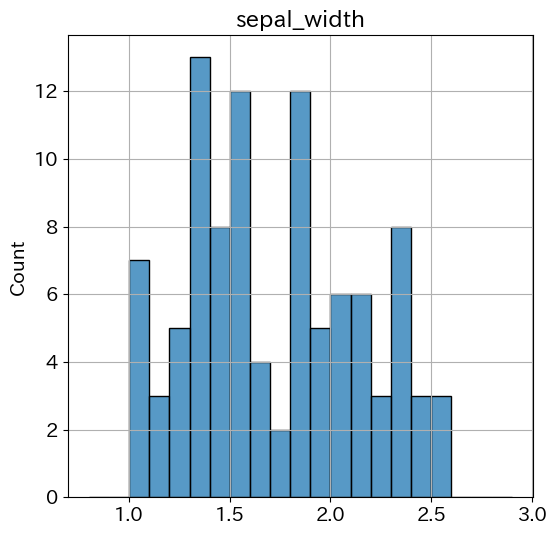

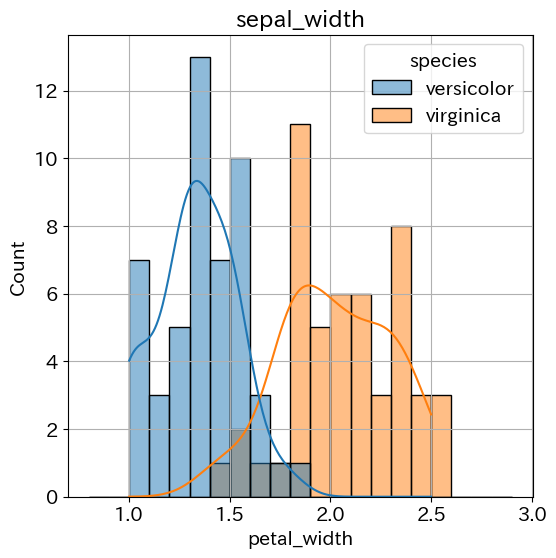

In [5]:
fig, ax = plt.subplots()
sns.histplot(x = X, bins=np.arange(0.8, 3.0, 0.1))
ax.set_title("sepal_width");

fig, ax = plt.subplots()
sns.histplot(data = df1, x = "petal_width", hue = "species",
             bins=np.arange(0.8, 3.0, 0.1), kde = True)
ax.set_title("sepal_width");

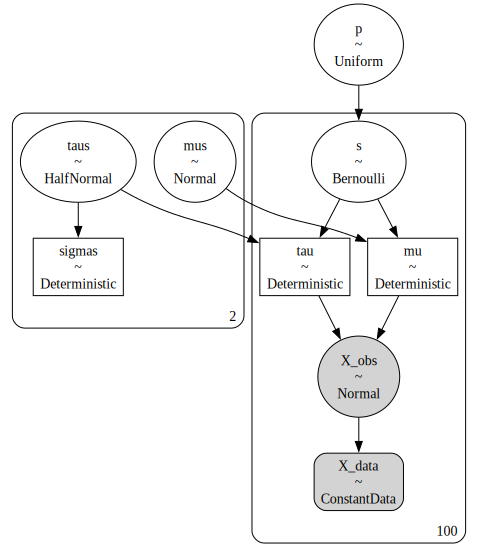

In [6]:
n_components = 2 # クラス数を指定
N = X.shape # 観測データ数

model = pm.Model()
with model:
    X_data = pm.ConstantData("X_data", X)

    # 潜在変数が1の値をとる確率
    p = pm.Uniform("p", lower = 0.0, upper = 1.0)

    # 潜在変数: pをもとに0, 1のいずれかを返す
    s = pm.Bernoulli("s", p=p, shape = N)

    # 各花の種類ごとの平均値とばらつきを確率変数で定義
    mus = pm.Normal("mus", mu=0, sigma=10, shape = n_components)
    taus = pm.HalfNormal("taus", sigma=10, shape = n_components)

    # 描画用に出力
    sigmas = pm.Deterministic("sigmas", 1 / pm.math.sqrt(taus))

    # 潜在変数から各クラスごと各観測値ごとの平均とばらつきを求める
    mu = pm.Deterministic("mu", mus[s])
    tau = pm.Deterministic("tau", taus[s])

    # X_obsとして正規分布に従う確率変数で定義
    X_obs = pm.Normal("X_obs", mu=mu, tau = tau, observed=X_data)

g = pm.model_to_graphviz(model)
display(g)

In [7]:
with model:
    idata = pm.sample(chains = 1,
                      draws = 2000,
                      target_accept = 0.99,
                      random_seed=42
    )

Sequential sampling (1 chains in 1 job)
CompoundStep
>NUTS: [p, mus, taus]
>BinaryGibbsMetropolis: [s]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 68 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


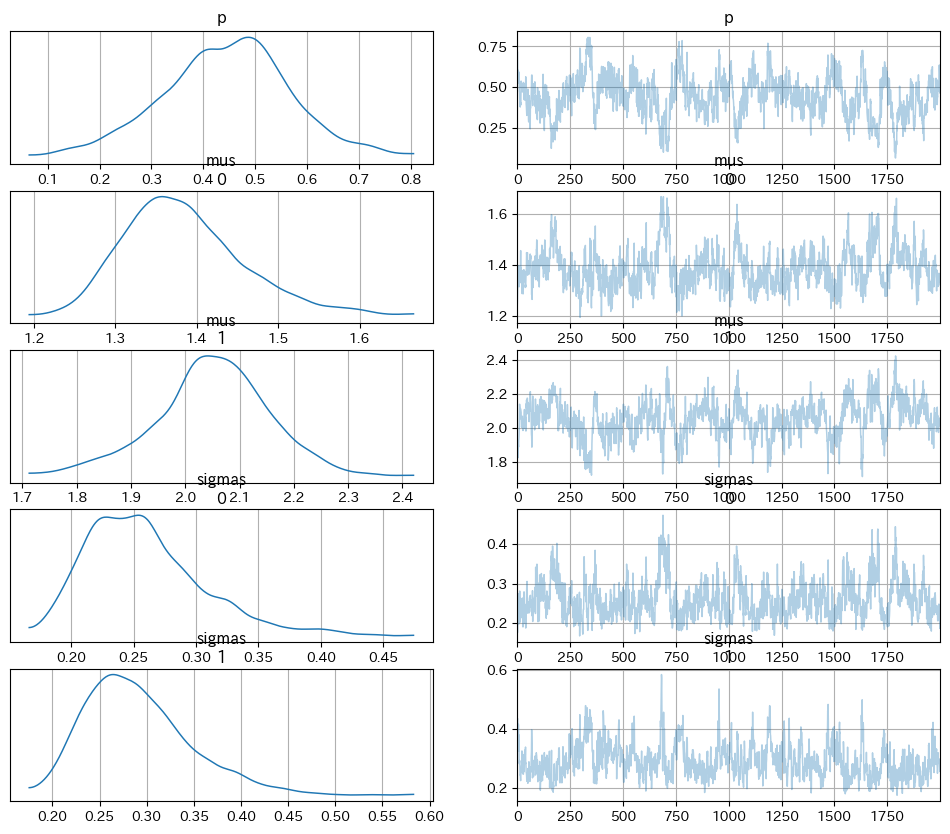

In [8]:
az.plot_trace(idata, compact=False, var_names=["p", "mus", "sigmas"])
plt.tight_layout;

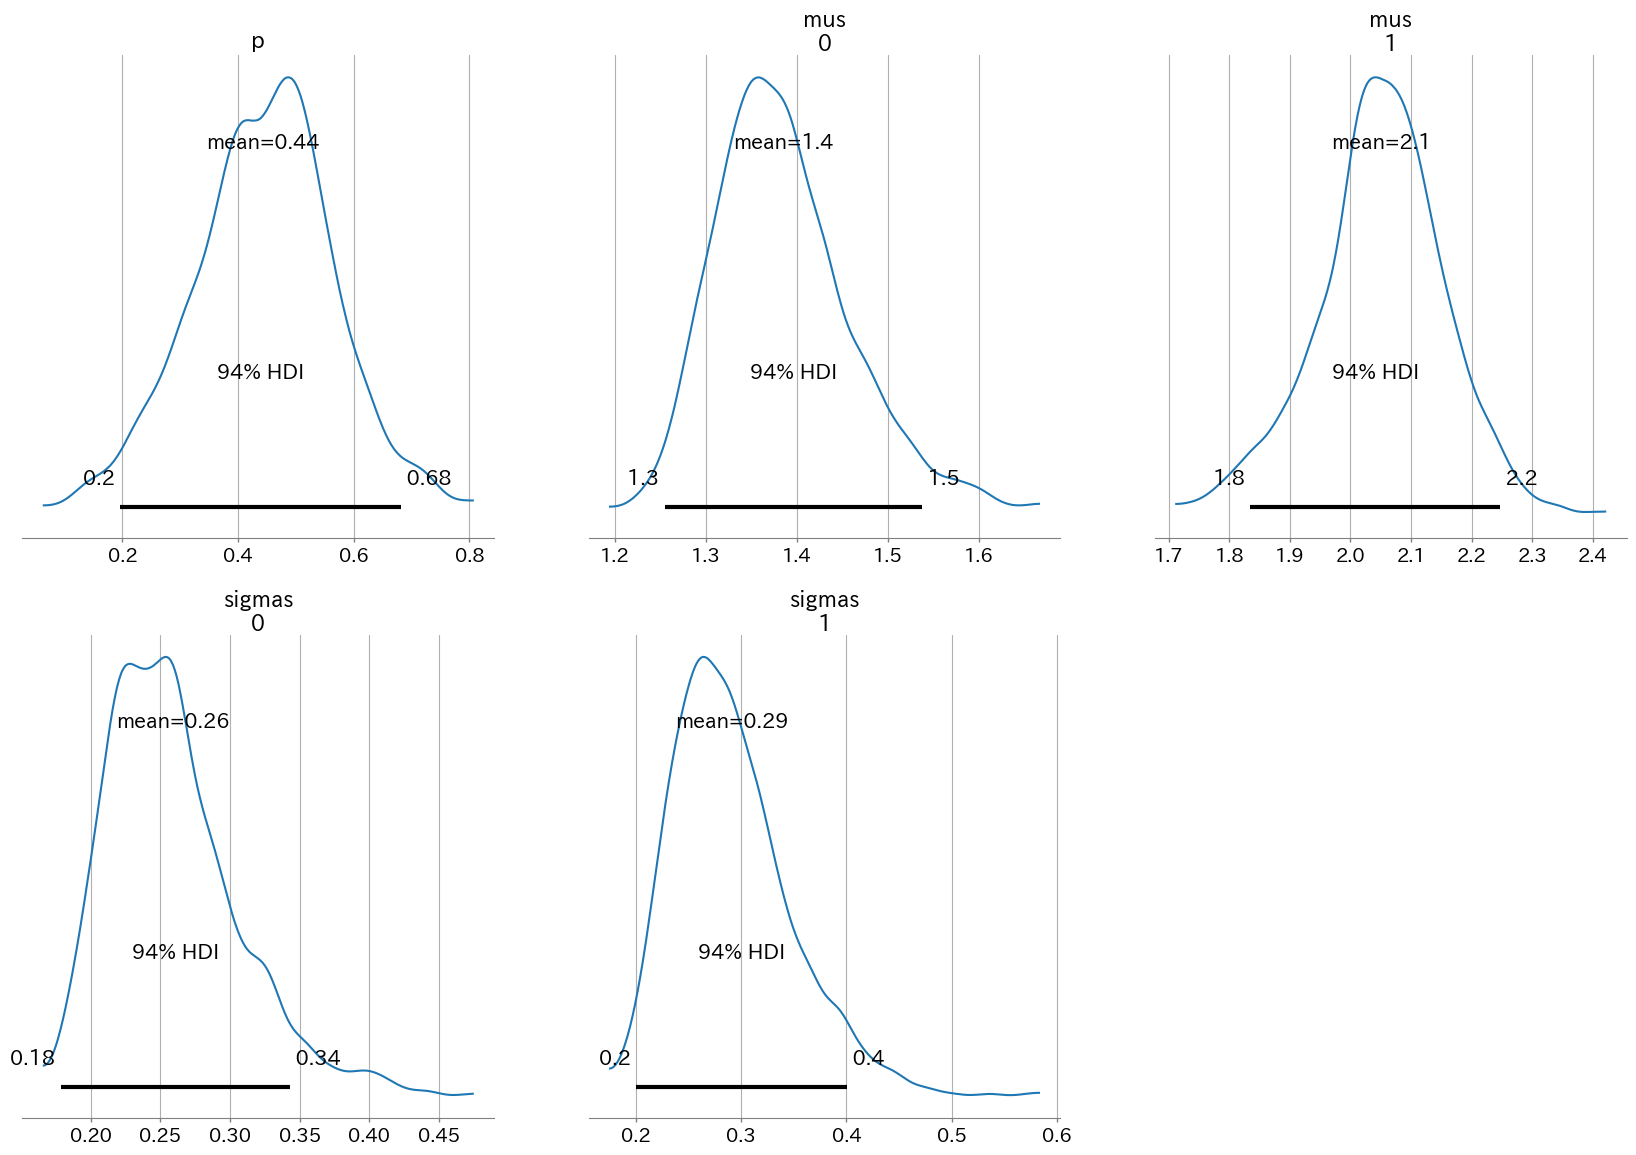

In [9]:
az.plot_posterior(idata, var_names=["p", "mus", "sigmas"])
plt.tight_layout;

In [10]:
summary = az.summary(idata, var_names = ["p", "mus", "sigmas"])
display(summary)

arviz - WARNING - Shape validation failed: input_shape: (1, 2000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
p,0.443,0.125,0.197,0.682,0.015,0.011,66.000,148.000,NaN
mus[0],1.386,0.077,1.255,1.538,0.009,0.006,82.000,113.000,NaN
mus[1],2.050,0.107,1.834,2.247,0.013,0.009,69.000,135.000,NaN
sigmas[0],0.259,0.047,0.178,0.343,0.005,0.004,106.000,139.000,NaN
sigmas[1],0.291,0.056,0.200,0.400,0.006,0.004,88.000,294.000,NaN


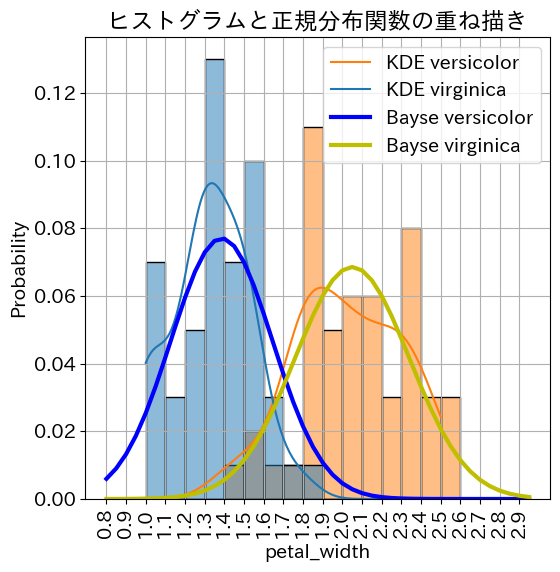

In [11]:

# 正規分布関数の定義
def norm(x, mu, sigma):
    return np.exp(-((x - mu)/sigma)**2/2) / (np.sqrt(2 * np.pi) * sigma)

# 推論結果から各パラメータの平均値を取得
mean = summary['mean']

# muの平均値取得
mean_mu0 = mean['mus[0]']
mean_mu1 = mean['mus[1]']

# sigmaの平均値取得
mean_sigma0 = mean['sigmas[0]']
mean_sigma1 = mean['sigmas[1]']

# 正規分布関数値の計算
x = np.arange(0.8, 3.0, 0.05)
delta = 0.1
y0 = norm(x, mean_mu0, mean_sigma0) * delta / n_components
y1 = norm(x, mean_mu1, mean_sigma1) * delta / n_components

# グラフ描画
bins = np.arange(0.8, 3.0, delta)
plt.rcParams['figure.figsize']=(6,6)
fig, ax = plt.subplots()
sns.histplot(data=df1, bins=bins, x='petal_width',
    hue='species', kde=True, ax=ax,  stat='probability')
ax.get_lines()[0].set_label('KDE versicolor')
ax.get_lines()[1].set_label('KDE virginica')
ax.plot(x, y0, c='b', lw=3, label='Bayse versicolor')
ax.plot(x, y1, c='y', lw=3, label='Bayse virginica')
ax.set_xticks(bins);
ax.xaxis.set_tick_params(rotation=90)
ax.set_title('ヒストグラムと正規分布関数の重ね描き')
plt.legend();

/Users/wakamatsuikuma/.pyenv/versions/3.10.7/lib/python3.10/site-packages/IPython/core/events.py:82: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/Users/wakamatsuikuma/.pyenv/versions/3.10.7/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


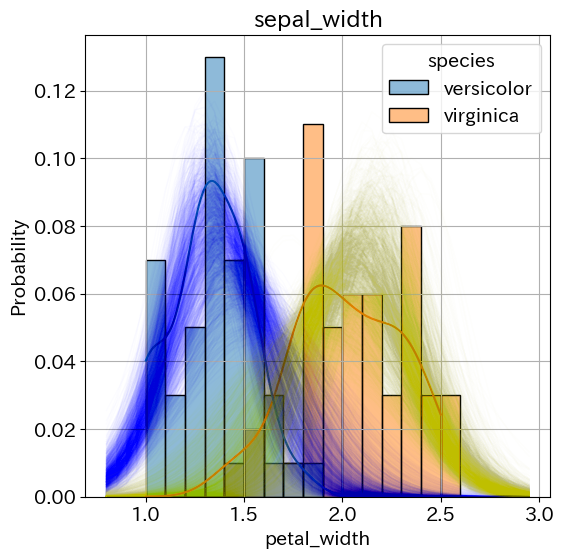

In [12]:
# 正規分布関数の定義
def norm(x, mu, sigma):
    return np.exp(-((x - mu)/sigma)**2/2) / (np.sqrt(2 * np.pi) * sigma)

# パラメーターの抽出
mus_ifr0 = idata["posterior"]["mus"].values.reshape(-1, 2)[:, 0].reshape(2000, 1)
mus_ifr1 = idata["posterior"]["mus"].values.reshape(-1, 2)[:, 1].reshape(2000, 1)
sigmas_ifr0 = idata["posterior"]["sigmas"].values.reshape(-1, 2)[:, 0].reshape(2000, 1)
sigmas_ifr1 = idata["posterior"]["sigmas"].values.reshape(-1, 2)[:, 1].reshape(2000, 1)

# 正規分布関数値の計算
x = np.arange(0.8, 3.0, 0.05)
delta = 0.1
y0 = norm(x, mus_ifr0, sigmas_ifr0) * delta / n_components
y1 = norm(x, mus_ifr1, sigmas_ifr1) * delta / n_components


fig, ax = plt.subplots()
sns.histplot(data = df1, x = "petal_width", hue = "species",
             bins=np.arange(0.8, 3.0, 0.1), kde = True, stat="probability")

for y in y0:
    ax.plot(x, y, c='b', lw=1, alpha = 0.01)
for y in y1:
    ax.plot(x, y, c='y', lw=1, alpha = 0.01)

ax.set_title("sepal_width");

In [13]:
value_list = [1.0, 1.5, 1.7, 2.0, 2.5]

df_heads = pd.DataFrame(None)

# petal_widthの値が1.0から2.5までそれぞれの値である先頭の行を抽出
for value in value_list:

    # petal_widthの値がvalueである行のみ抽出
    w = df1.query('petal_width == @value', engine='python')

    # 先頭の１行を抽出し、df_headsに連結
    df_heads = pd.concat([df_heads, w.head(1)], axis=0)

# 結果確認
display(df_heads)

,sepal_length,sepal_width,petal_length,petal_width,species
7,4.900,2.400,3.300,1.000,versicolor
1,6.400,3.200,4.500,1.500,versicolor
27,6.700,3.000,5.000,1.700,versicolor
60,6.500,3.200,5.100,2.000,virginica
50,6.300,3.300,6.000,2.500,virginica


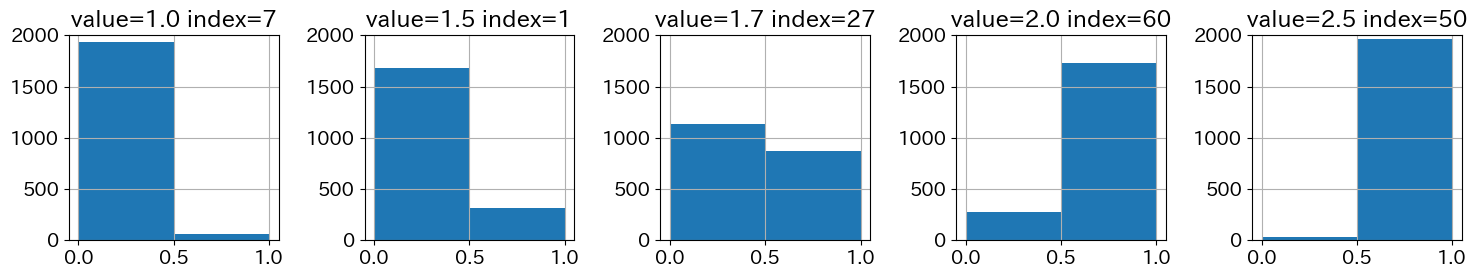

In [14]:
# df_headsのインデックスを抽出
indexes, n_indexes = df_heads.index, len(df_heads)

# 潜在変数sのサンプル値から、index=7, 1, 27, 60, 50の値を抽出
sval = idata.posterior['s'][:,:,indexes].values.reshape(-1,n_indexes).T

# それぞれのケースでヒストグラムの描画
plt.rcParams['figure.figsize']=(15,3)
list = df_heads['petal_width']
fig, axes = plt.subplots(1, n_indexes)
for ax, item, value, index in zip(axes, sval, list, indexes):
    f = pd.DataFrame(item)
    f.hist(ax=ax, bins=2)
    ax.set_ylim(0,2000)
    ax.set_title(f'value={value} index={index}')
plt.tight_layout();
     